In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from betavae import BVAE
import supervised_bvae

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools

from sklearn.model_selection import train_test_split

In [2]:
# you may wish to modify these first three values if ablating
# beta is as in beta-vae
# alpha is the weight for reconstructing the latent supervision vs. the original image
# (so higher alpha -> more weight on reconstructing the USE embedding or whatever)

num_epochs = 50
batch_size = 64
gradient_accumulation_steps = 1
lr = 1e-3

updates_per_epoch = 1

In [3]:
rand_state = 420

torch.manual_seed(rand_state)
np.random.seed(rand_state)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
shapes_meta = pd.read_csv('shapes.csv')
shapes_meta.head()

,shape,color,r,g,b,wscale,hscale,rotation,skew,xcenter,ycenter,hatch,shadow
0,heptagon,almost black,0.027451,0.050980,0.050980,1.481863,1.445323,0.000000,0.000000,30.873125,-4.386932,NaN,False
1,rectangle,mustard brown,0.674510,0.494118,0.015686,0.687809,0.687809,129.534566,-24.544234,0.000000,0.000000,*,False
2,pentagon,cool blue,0.286275,0.517647,0.721569,1.000000,1.000000,0.000000,0.000000,0.000000,-0.578535,NaN,False
3,triangle,olive green,0.403922,0.478431,0.015686,0.908967,0.908967,101.475968,0.000000,0.000000,0.000000,NaN,True
4,ellipse,brownish yellow,0.788235,0.690196,0.011765,0.743424,0.692907,298.500376,0.000000,4.407094,16.628985,NaN,False


In [6]:
resize = transforms.Resize(64)
shapes = resize(torch.load('shapes.pt').permute(0, 3, 1, 2) / 255)
del resize
shapes.shape

torch.Size([20000, 3, 64, 64])

In [7]:
train, valid = train_test_split(shapes, test_size=0.1, random_state=rand_state)
train_meta, valid_meta = train_test_split(shapes_meta, test_size=0.1, random_state=rand_state)
del shapes

In [8]:
import tensorflow as tf
import tensorflow_hub as hub

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
#use_model = hub.load(module_url)
import clip
clip_model, preprocess = clip.load("ViT-B/32")
clip_model.eval()



def encode_USE(input_DF):
    return torch.tensor(use_model(input_DF.color.values).numpy())

def encode_CLIP(input_DF):
    tokens = clip.tokenize(input_DF.color.values)
    to_return = torch.empty(size=(0,512))
    for token in tqdm(tokens):
        
        to_return = torch.cat((to_return, clip_model.encode_text(token[None,:]).detach()), dim=0)
    return to_return

# flags

language_supervision = True
encoder = encode_CLIP



train_meta, valid_meta = train_test_split(shapes_meta, test_size=0.1, random_state=rand_state)

if not language_supervision:
    print('creating direct supervision')
    train_meta = torch.tensor(train_meta.iloc[:,2:5].values).float()
    valid_meta = torch.tensor(valid_meta.iloc[:,2:5].values).float()
else:
    print('creating language embedding supervision')
    train_meta = encoder(train_meta)
    valid_meta = encoder(valid_meta)


2023-04-28 13:52:29.506262: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 13:52:31.155750: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


creating language embedding supervision


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:41<00:00, 12.41it/s]


In [9]:
supervised_dim = train_meta.shape[1]
supervised_dim

512

In [10]:
from torch.utils.data import Dataset

bce_loss = nn.BCELoss(reduction='sum')
mse_loss = nn.MSELoss(reduction='sum')
def vae_loss(x, mu, var, recon, beta):
    recon_loss = bce_loss(recon, x)
    kl = -torch.sum(1 + var - torch.pow(mu, 2) - torch.exp(var)) / 2
    return (recon_loss + beta * kl) / x.size(0)

def supervised_vae_loss(x, yhat, supervision, mu, var, recon, beta, alpha):
    a = mse_loss(yhat, supervision)
    return a, vae_loss(x, mu, var, recon, beta) + a*alpha

class DatasetWrapper(Dataset):
    def __init__(self, imgs, latent_supervision):
        self.imgs = imgs
        self.latent_supervision = latent_supervision
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        return self.imgs[idx], self.latent_supervision[idx]

Epoch 1, Experiment clip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:33<00:00,  7.88it/s]

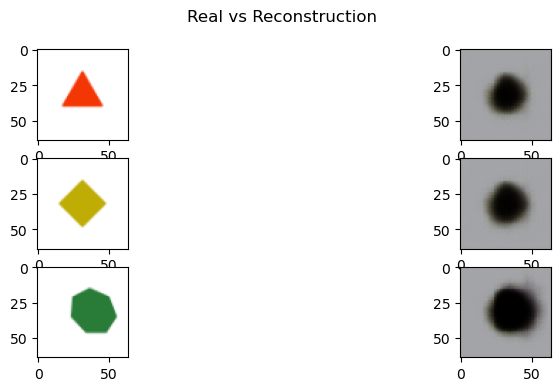

Experiment clip, Epoch 1 | train loss 10792.88 | valid loss 8788.68 | supervision loss 3436.98: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:37<00:00,  7.59it/s]
Epoch 2, Experiment clip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:32<00:00,  8.49it/s]

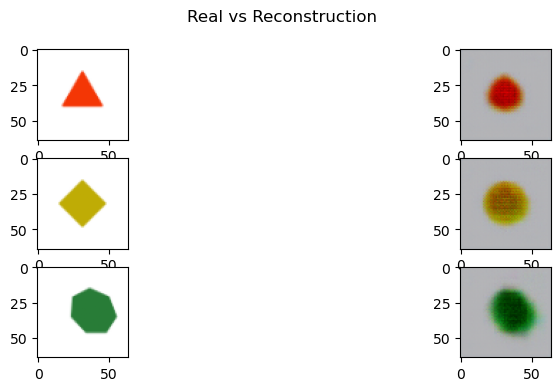

Experiment clip, Epoch 2 | train loss 7433.38 | valid loss 6646.33 | supervision loss 1518.44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:34<00:00,  8.23it/s]
Epoch 3, Experiment clip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:32<00:00,  8.61it/s]

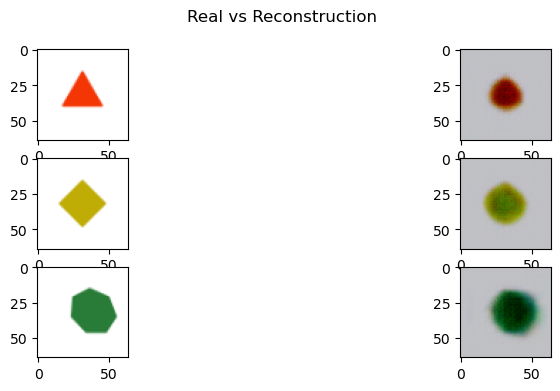

Experiment clip, Epoch 3 | train loss 6151.87 | valid loss 5696.35 | supervision loss 1316.81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:33<00:00,  8.36it/s]
Epoch 4, Experiment clip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:31<00:00,  9.09it/s]

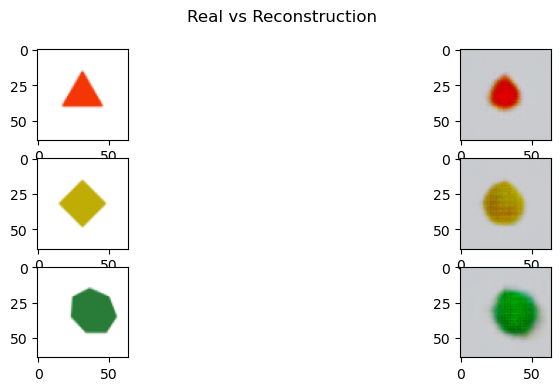

Experiment clip, Epoch 4 | train loss 5359.37 | valid loss 5036.23 | supervision loss 1250.26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:33<00:00,  8.43it/s]
Epoch 5, Experiment clip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:31<00:00,  9.05it/s]

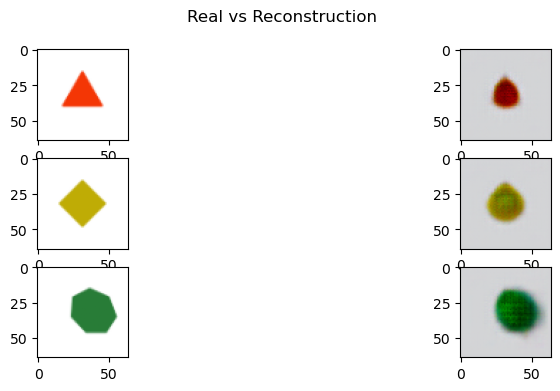

Experiment clip, Epoch 5 | train loss 4762.98 | valid loss 4519.39 | supervision loss 1201.53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:33<00:00,  8.44it/s]
Epoch 6, Experiment clip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:33<00:00,  8.26it/s]

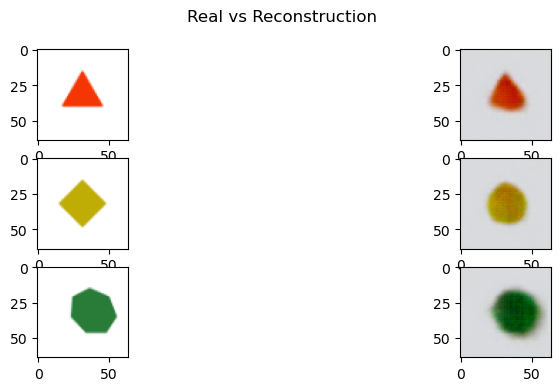

Experiment clip, Epoch 6 | train loss 4277.13 | valid loss 4048.32 | supervision loss 1140.19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:35<00:00,  7.91it/s]
Epoch 7, Experiment clip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:31<00:00,  8.81it/s]

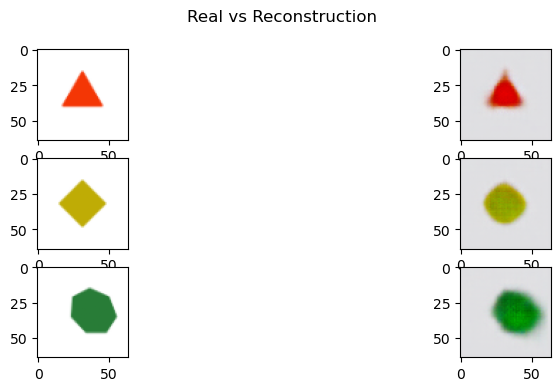

Experiment clip, Epoch 7 | train loss 3896.23 | valid loss 3698.38 | supervision loss 1083.99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:33<00:00,  8.38it/s]
Epoch 8, Experiment clip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:31<00:00,  8.97it/s]

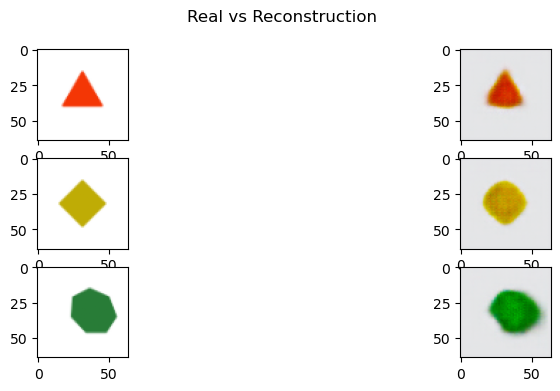

Experiment clip, Epoch 8 | train loss 3595.83 | valid loss 3620.45 | supervision loss 1046.52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:33<00:00,  8.48it/s]
Epoch 9, Experiment clip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:32<00:00,  8.68it/s]

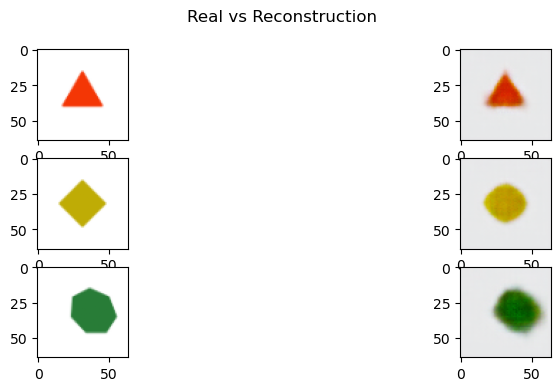

Experiment clip, Epoch 9 | train loss 3378.78 | valid loss 3330.14 | supervision loss 1029.49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:33<00:00,  8.31it/s]
Epoch 10, Experiment clip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:33<00:00,  8.28it/s]

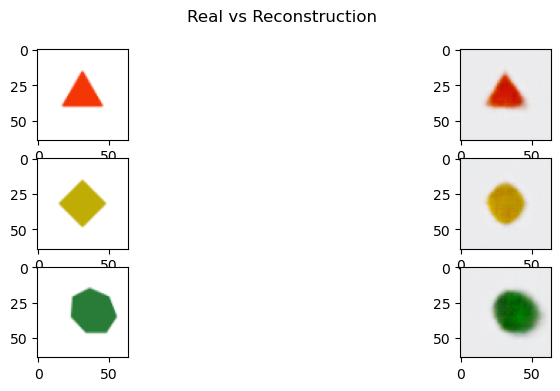

Experiment clip, Epoch 10 | train loss 3191.41 | valid loss 3138.42 | supervision loss 1017.43: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:35<00:00,  7.96it/s]
Epoch 11, Experiment clip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:34<00:00,  8.44it/s]

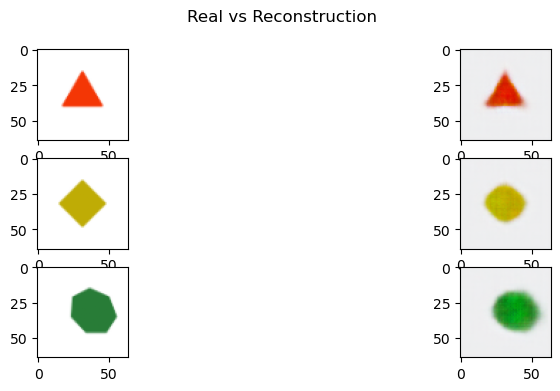

Experiment clip, Epoch 11 | train loss 3041.19 | valid loss 2940.49 | supervision loss 1007.89: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:35<00:00,  7.89it/s]
Epoch 12, Experiment clip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:34<00:00,  8.15it/s]

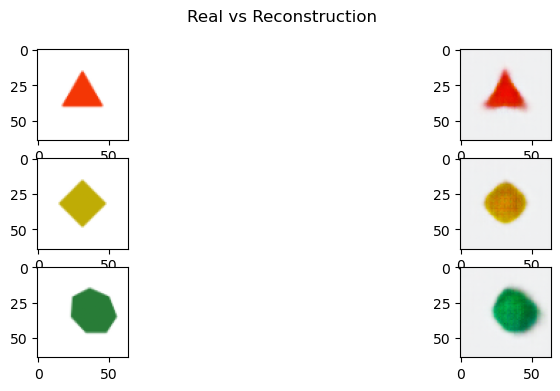

Experiment clip, Epoch 12 | train loss 2913.08 | valid loss 3034.29 | supervision loss 999.79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:36<00:00,  7.80it/s]
Epoch 13, Experiment clip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:34<00:00,  8.80it/s]

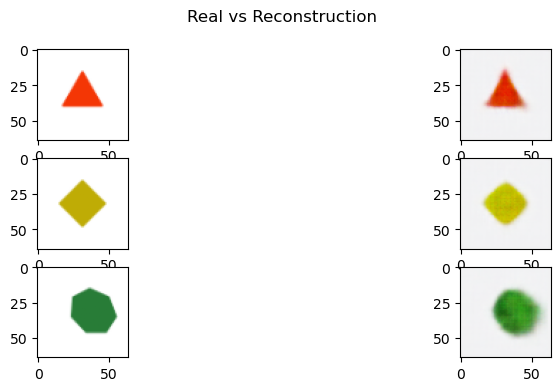

Experiment clip, Epoch 13 | train loss 2810.43 | valid loss 2773.49 | supervision loss 991.03: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:35<00:00,  7.86it/s]
Epoch 14, Experiment clip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:32<00:00,  8.01it/s]

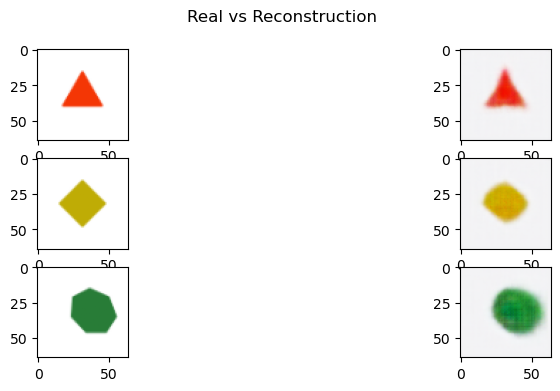

Experiment clip, Epoch 14 | train loss 2737.18 | valid loss 2778.53 | supervision loss 987.33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:34<00:00,  8.15it/s]
Epoch 15, Experiment clip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:37<00:00,  8.61it/s]

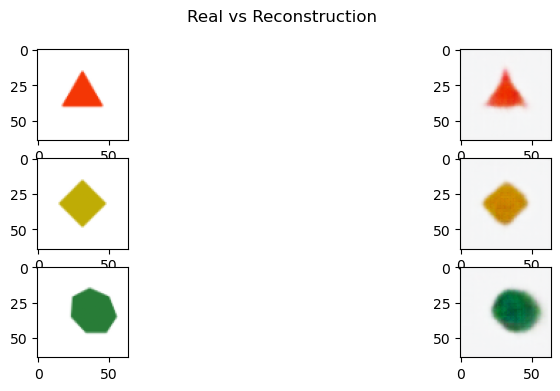

Experiment clip, Epoch 15 | train loss 2636.17 | valid loss 2712.57 | supervision loss 975.20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:39<00:00,  7.15it/s]
Epoch 16, Experiment clip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:32<00:00,  8.89it/s]

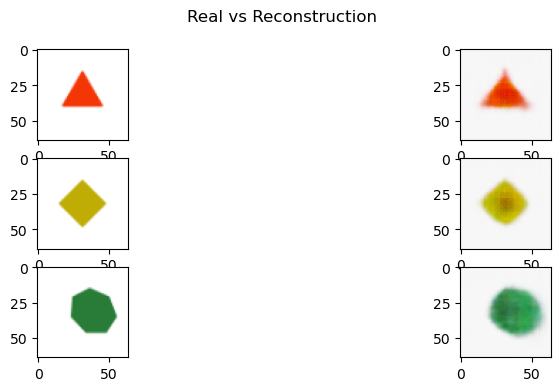

Experiment clip, Epoch 16 | train loss 2585.57 | valid loss 2896.61 | supervision loss 972.87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:33<00:00,  8.39it/s]
Epoch 17, Experiment clip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:31<00:00,  8.83it/s]

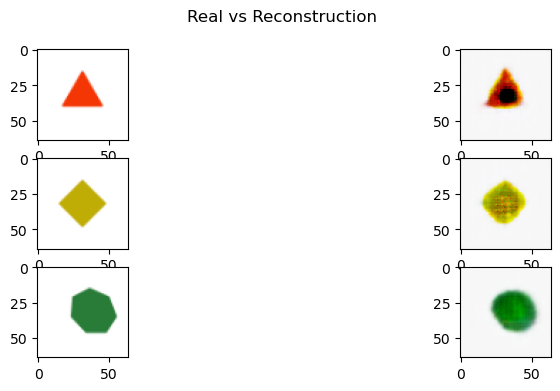

Experiment clip, Epoch 17 | train loss 2512.22 | valid loss 2964.84 | supervision loss 961.19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:33<00:00,  8.41it/s]
Epoch 18, Experiment clip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:31<00:00,  8.66it/s]

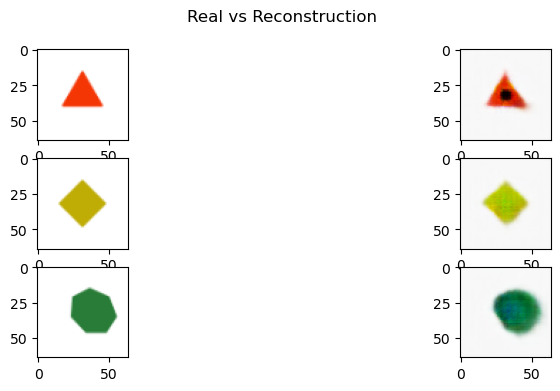

Experiment clip, Epoch 18 | train loss 2487.88 | valid loss 2567.62 | supervision loss 961.22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:33<00:00,  8.39it/s]
Epoch 19, Experiment clip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:32<00:00,  8.48it/s]

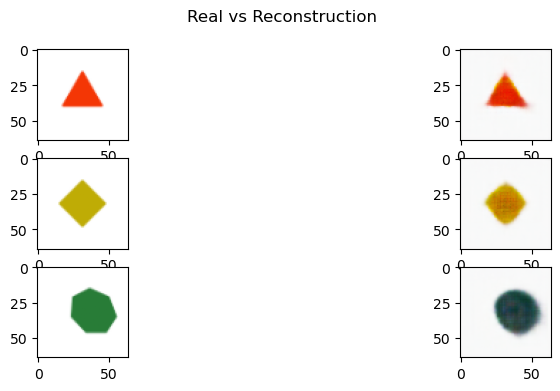

Experiment clip, Epoch 19 | train loss 2423.83 | valid loss 2478.14 | supervision loss 953.48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:33<00:00,  8.31it/s]
Epoch 20, Experiment clip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:31<00:00,  8.78it/s]

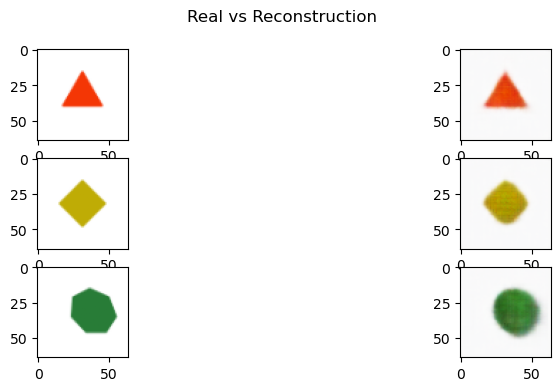

Experiment clip, Epoch 20 | train loss 2380.58 | valid loss 2433.67 | supervision loss 945.65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:33<00:00,  8.43it/s]
Epoch 21, Experiment clip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:30<00:00,  8.92it/s]

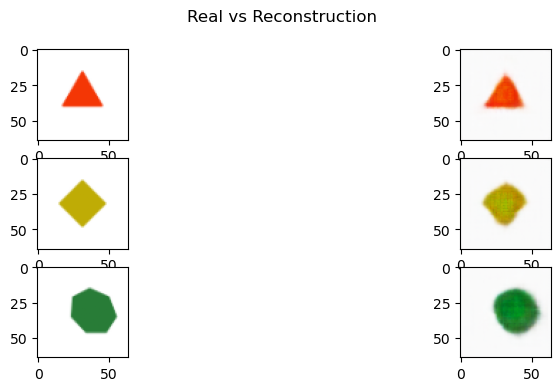

Experiment clip, Epoch 21 | train loss 2364.00 | valid loss 2461.23 | supervision loss 944.39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:32<00:00,  8.70it/s]
Epoch 22, Experiment clip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:30<00:00,  8.69it/s]

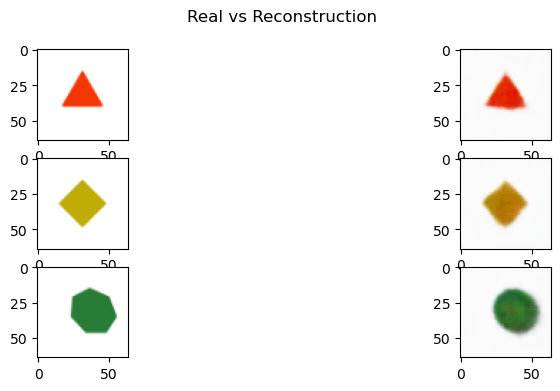

Experiment clip, Epoch 22 | train loss 2321.99 | valid loss 2405.22 | supervision loss 942.17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:32<00:00,  8.63it/s]
Epoch 23, Experiment clip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:31<00:00,  9.64it/s]

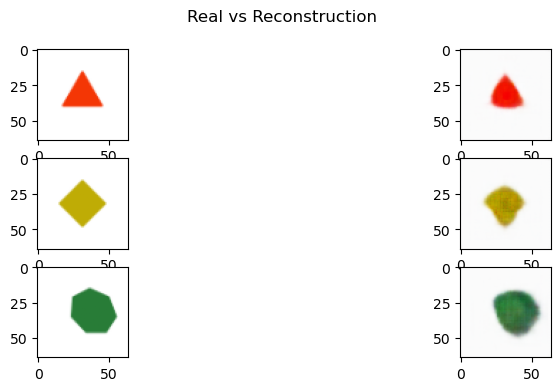

Experiment clip, Epoch 23 | train loss 2282.68 | valid loss 2428.28 | supervision loss 932.88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:33<00:00,  8.45it/s]
Epoch 24, Experiment clip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:31<00:00,  8.98it/s]

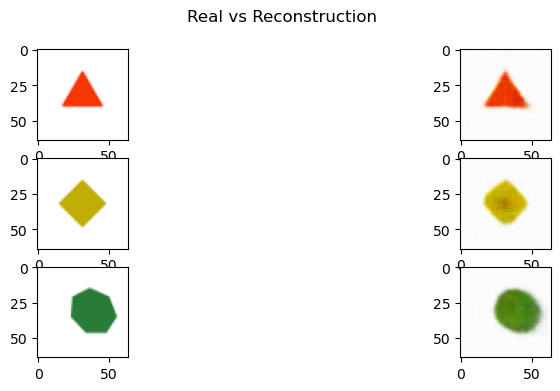

Experiment clip, Epoch 24 | train loss 2258.47 | valid loss 2314.75 | supervision loss 929.22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:33<00:00,  8.52it/s]
Epoch 25, Experiment clip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:32<00:00,  9.21it/s]

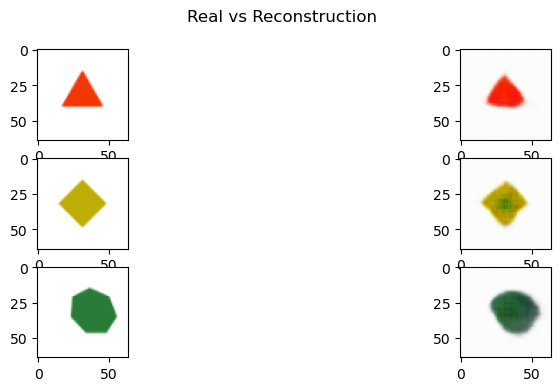

Experiment clip, Epoch 25 | train loss 2241.72 | valid loss 2340.12 | supervision loss 928.22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:33<00:00,  8.35it/s]
Epoch 26, Experiment clip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:31<00:00,  7.39it/s]

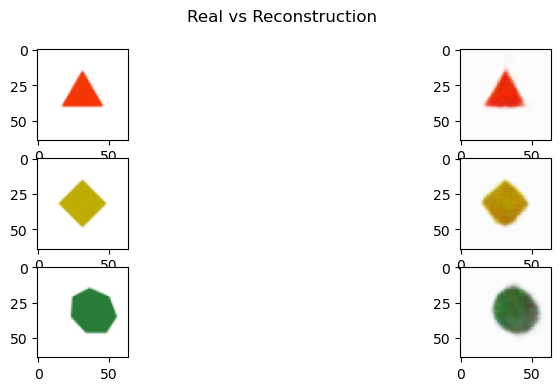

Experiment clip, Epoch 26 | train loss 2220.02 | valid loss 2267.97 | supervision loss 924.71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:33<00:00,  8.45it/s]
Epoch 27, Experiment clip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:31<00:00,  8.94it/s]

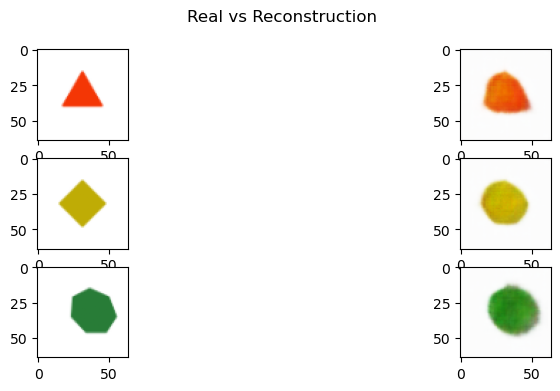

Experiment clip, Epoch 27 | train loss 2200.41 | valid loss 3177.57 | supervision loss 921.85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:33<00:00,  8.45it/s]
Epoch 28, Experiment clip:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 280/282 [00:31<00:00,  9.25it/s]

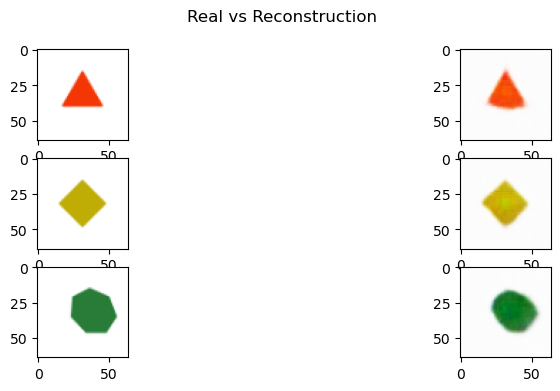

Experiment clip, Epoch 28 | train loss 2231.28 | valid loss 2344.76 | supervision loss 940.13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:33<00:00,  8.53it/s]
Epoch 29, Experiment clip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:30<00:00,  8.83it/s]

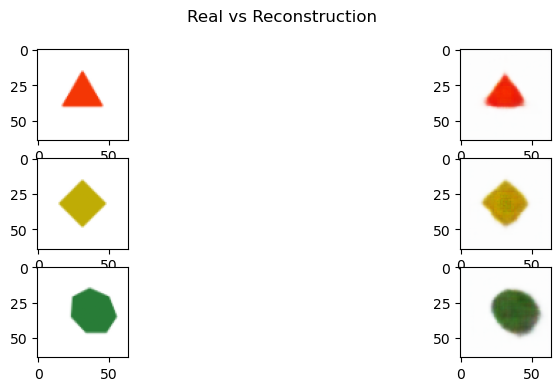

Experiment clip, Epoch 29 | train loss 2173.19 | valid loss 2267.68 | supervision loss 918.45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:32<00:00,  8.66it/s]
Epoch 30, Experiment clip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 281/282 [00:31<00:00,  8.44it/s]

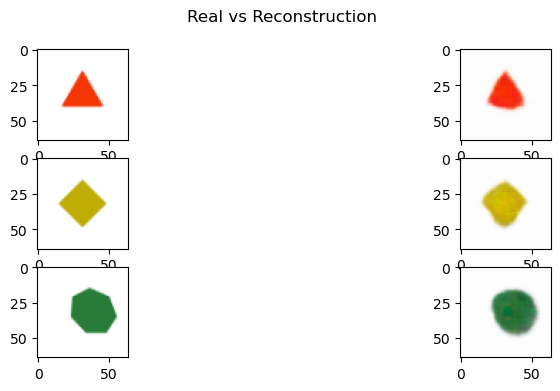

Experiment clip, Epoch 30 | train loss 2156.19 | valid loss 2317.82 | supervision loss 916.16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [00:32<00:00,  8.55it/s]
Epoch 31, Experiment clip:  10%|███████████████▉                                                                                                                                                       | 27/282 [00:02<00:27,  9.15it/s]

In [28]:
# only run this cell if you have to

from torch.utils.data import DataLoader

def run_train(z_dim, beta, alpha, exp_title=''):
    net = supervised_bvae.SupervisedBVAE(z_dim, supervised_out=supervised_dim)
    net = net.to(device)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)

    train_dataloader = DataLoader(DatasetWrapper(train, train_meta), batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(DatasetWrapper(valid, valid_meta), batch_size=batch_size, shuffle=False)

    num_batches = len(train_dataloader)
    num_valid_batches = len(valid_dataloader)


    train_losses, valid_losses = [], []
    train_supervision_losses = []

    update_idxs = set([i * (num_batches // updates_per_epoch)
        for i in range(1, updates_per_epoch)] + [num_batches])

    best_valid = 1e9
    for epoch in range(1, 1+num_epochs):
        total_loss = 0.0 
        total_supervision_loss = 0.0
        pbar = tqdm(train_dataloader, desc=f"Epoch {epoch}, Experiment {exp_title}", leave=True, total=num_batches)
        optimizer.zero_grad()
        for idx, batch in enumerate(pbar, start=1):
            x, latent_supervision = batch
            x = x.to(device) # how inefficient is it to stream batches to the device like this? I guess it saves GPU memory

            recon, mu, var, _, yhat = net(x)

            supervision_loss, loss = supervised_vae_loss(x, yhat, latent_supervision, mu, var, recon, beta, alpha)

            total_loss += loss.item() / gradient_accumulation_steps
            total_supervision_loss += supervision_loss.item() / gradient_accumulation_steps
            loss = loss / gradient_accumulation_steps
            loss.backward()


            if (idx % gradient_accumulation_steps == 0) or (idx == num_batches):
                optimizer.step()
                optimizer.zero_grad()

            if idx in update_idxs:
                avg_valid_loss = 0.0

                displays = []
                net.eval()
                with torch.no_grad():
                    for batch in valid_dataloader:
                        x, latent_supervision = batch
                        recon, mu, var, z, yhat = net(x)
                        _, loss = supervised_vae_loss(x, yhat, latent_supervision, mu, var, recon, beta, alpha)
                        avg_valid_loss += loss.item() / num_valid_batches
                        if not displays:
                            net.random_z = tuple(z[0].detach().cpu().numpy())
                            displays = [
                                (x[0].permute(1, 2, 0).cpu().numpy(), recon[0].permute(1, 2, 0).cpu().numpy()), 
                                (x[1].permute(1, 2, 0).cpu().numpy(), recon[1].permute(1, 2, 0).cpu().numpy()),
                                (x[2].permute(1, 2, 0).cpu().numpy(), recon[2].permute(1, 2, 0).cpu().numpy())
                            ]

                    if avg_valid_loss < best_valid:
                        torch.save(net, f'models/{beta}-supbvae-{z_dim}dim-{alpha}alpha-clip')
                        best_valid = avg_valid_loss

                    valid_losses.append(avg_valid_loss)

                    if idx == num_batches:
                        fig, axes = plt.subplots(3, 2)
                        fig.suptitle('Real vs Reconstruction')
                        fig.set_size_inches(10, 4)
                        for (ax1, ax2), (im1, im2) in zip(axes, displays):
                            ax1.imshow(im1)
                            ax2.imshow(im2)
                        plt.show()
                net.train()


                pbar.set_description(f"Experiment {exp_title}, Epoch {epoch} | train loss {total_loss / idx:.2f}" + \
                                    f" | valid loss {avg_valid_loss:.2f}" + f' | supervision loss {total_supervision_loss / idx:.2f}')
                train_losses.append(total_loss / idx) 
                train_supervision_losses.append(total_supervision_loss / idx)



z_dims = [8, 16, 64]
betas = [0.5, 1, 2.5]
alphas = [0.1, 0.5, 1, 2.5]
run_train(16, 2.5, 1, exp_title='clip')
#for idx, (z_dim, beta, alpha) in enumerate(itertools.product(z_dims, betas, alphas)):
#    run_train(z_dim, beta, alpha, exp_title=str(idx))

In [11]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_model = hub.load(module_url)

#print(use_model('asdf'))
#plt.plot(train_losses, label='Train Loss')
#plt.plot(valid_losses, label='Valid Loss')
#plt.plot(train_supervision_losses, label='Train Supervision Loss')
#plt.legend()
#plt.savefig('trainplot.png')

tensor([1.0077e+01+0.j, 2.6964e+00+0.j, 2.4641e+00+0.j, 1.8294e+00+0.j, 1.5647e+00+0.j,
        1.2140e+00+0.j, 7.1514e-01+0.j, 9.3131e-01+0.j, 8.8398e-01+0.j, 3.1883e-01+0.j,
        9.7154e-02+0.j, 5.9912e-03+0.j, 5.5348e-03+0.j, 4.3281e-03+0.j, 3.9978e-03+0.j,
        2.6914e-03+0.j])
tensor([10.0873+0.j,  2.7064+0.j,  2.4741+0.j,  1.8394+0.j,  1.5747+0.j,  1.2240+0.j,
         0.7251+0.j,  0.9413+0.j,  0.8940+0.j,  0.3288+0.j,  0.1072+0.j,  0.0160+0.j,
         0.0155+0.j,  0.0127+0.j,  0.0143+0.j,  0.0140+0.j])
3.24492
9.067785


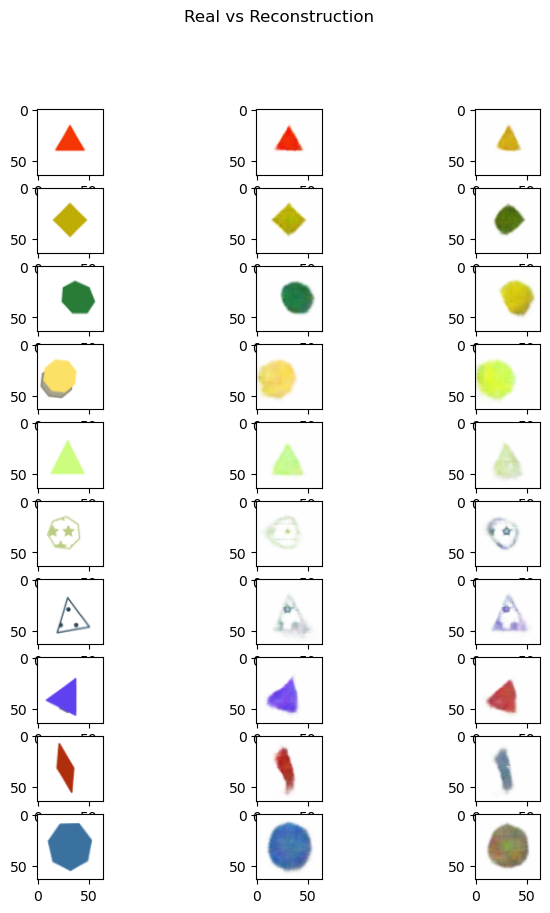

<Figure size 640x480 with 0 Axes>

In [29]:
import importlib
importlib.reload(supervised_bvae)

model = torch.load('models/2.5-supbvae-16dim-1alpha-clip')
W = model.z_to_out_map.weight.detach()
print(torch.linalg.eig(W.transpose(0, 1) @ W).eigenvalues)
print(torch.linalg.eig(W.transpose(0, 1) @ W + 0.01*torch.eye(16)).eigenvalues)
model.eval()
valid_dataset = DatasetWrapper(valid, valid_meta)
displays = []
ys = []
residuals = []
with torch.no_grad():
    for sample_idx in range(10):
        x, latent_supervision = valid_dataset[sample_idx]
        x = x[None,:]
        _, next_latent_supervision = valid_dataset[sample_idx+1]
        recon, mu, var, z, yhat = model(x)
        
        ys += [torch.norm(latent_supervision)]
        residuals += [torch.norm(latent_supervision - yhat)]
        
        recon2 = model.forward_with_supervision(x, next_latent_supervision, smoothing=0.5)
        displays += [[x[0].permute(1, 2, 0).cpu().numpy(),
                       recon[0].permute(1, 2, 0).cpu().numpy(), recon2[0].permute(1, 2, 0).cpu().numpy()]]
print(np.mean(residuals))
print(np.mean(ys))

fig, axes = plt.subplots(10, 3)
fig.suptitle('Real vs Reconstruction')
fig.set_size_inches(8, 10)
for (ax1, ax2, ax3), (im1, im2, im3) in zip(axes, displays):
    ax1.imshow(im1)
    ax2.imshow(im2)
    ax3.imshow(im3)
plt.show()
plt.savefig('asdf.png')